# Retail Data Analytics
<br>
This notebook contains the code for training and deploying a retail data analytics model. The goal is to estimate the weekly sales of a store given the input features.
<br>
The data is stored in csv files. There is one csv file containing the training data (train.csv) and one containing the test data (test.csv). Additionally, one can find all feature names in a csv file calls "features_list.csv". 

In [15]:
import pandas as pd
import boto3
import sagemaker

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Load Data to S3

In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [3]:
import os
# folder containing the training and test data
data_dir = "data_converted"

# set prefix, a descriptive name for a directory  
prefix = "retail_analytics_data"

# upload all data to S3
train_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "train.csv"), bucket=bucket, key_prefix=prefix)
test_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "test.csv"), bucket=bucket, key_prefix=prefix)

### Test 
Check if uploading the data to S3 was successfull.

In [4]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

retail_analytics_data/test.csv
retail_analytics_data/train.csv
Test passed!


## Train the Benchmark Model

<br>
As benchmark model a linear regression model should be trained. The model is trained using the sklearn library. The training code is located in the file "train_linear_regression.py" within the source folder.

In [5]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'source/train_linear_regression.py'

sklearn = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session)

### Train

In [6]:
%%time

# Train the estimator on S3 training data
sklearn.fit({"train": train_input})

2021-01-02 12:42:52 Starting - Starting the training job...
2021-01-02 12:43:15 Starting - Launching requested ML instancesProfilerReport-1609591371: InProgress
......
2021-01-02 12:44:22 Starting - Preparing the instances for training......
2021-01-02 12:45:18 Downloading - Downloading input data...
2021-01-02 12:45:44 Training - Downloading the training image..2021-01-02 12:46:06,301 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-02 12:46:06,302 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-02 12:46:06,312 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-02 12:46:06,749 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-02 12:46:06,762 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-02 12:46:06,773 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus i

### Deploy

In [7]:
%%time

# deploy the model to create a predictor
predictor = sklearn.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------!CPU times: user 327 ms, sys: 23.4 ms, total: 350 ms
Wall time: 9min 32s


### Evaluate

In [8]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

In [18]:
num_samples_test = 100
test_y_preds = predictor.predict(test_x[:num_samples_test].values)

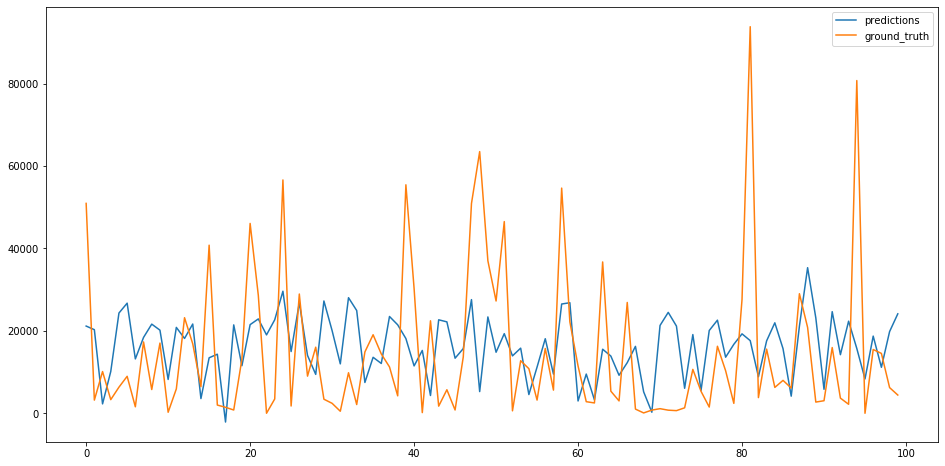

In [24]:
# plot the results
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds)
plt.plot(test_y[:num_samples_test])
plt.legend(("predictions", "ground_truth"))
plt.show()

## Clean Up Resources

In [25]:
predictor.delete_endpoint()

In [26]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'AFC2807E65E4C914',
   'HostId': '/hKMXZPyhXbfBRoJ7OSTtriqsRx/8hnEkrNYXPz+NfxxuP0X4ltoNp9D2su4Nkqdngspy1xD3Gs=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': '/hKMXZPyhXbfBRoJ7OSTtriqsRx/8hnEkrNYXPz+NfxxuP0X4ltoNp9D2su4Nkqdngspy1xD3Gs=',
    'x-amz-request-id': 'AFC2807E65E4C914',
    'date': 'Sat, 02 Jan 2021 13:23:08 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker-scikit-learn-2021-01-02-12-42-51-847/rule-output/ProfilerReport-1609591371/profiler-output/profiler-reports/LoadBalancing.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-02-12-42-51-847/profiler-output/system/incremental/2021010212/1609591500.algo-1.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-02-12-42-51-847/rule-output/ProfilerReport-1609591371/profiler-output/profiler-reports/BatchSize.json'},
   {'Key': 'sagemaker-scikit